Centro de Estudos e Sistemas Avançados do Recife

Pós-graduação em Engenharia e Análise de Dados

Disciplina de RNA e Deep Learning

Professor: Vitor Casadei

Aluno: Anísio Pereira Batista Filho

# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\3372919847.py:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if option is 'iris':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\3372919847.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'moon':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\3372919847.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'circles':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\3372919847.p

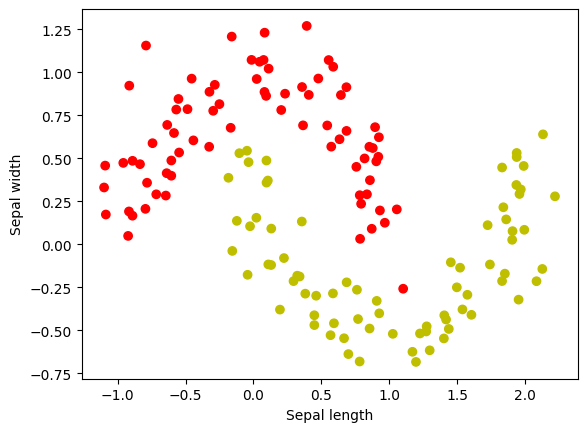

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option is 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option is 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option is 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option is 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 35),
            nn.ReLU(),
            nn.Linear(35, 35),
            nn.ReLU(),
            nn.Linear(35,3),
        )
    
    def forward(self, x):
        x = self.dense(x)
        
        return x
    
model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
    (2): Linear(in_features=35, out_features=35, bias=True)
    (3): ReLU()
    (4): Linear(in_features=35, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)
                
                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)
                
                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0017)


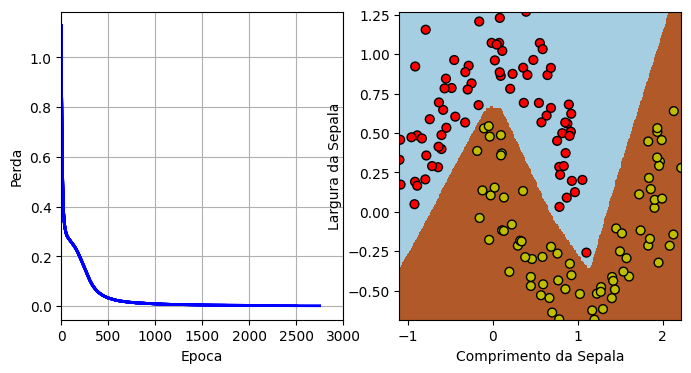

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})
    
print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [12]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([35, 2])
tensor([[ 1.0769,  0.1761],
        [ 0.6754,  0.3917],
        [ 1.6088,  0.4912],
        [ 0.6411, -0.5267],
        [ 0.6986, -0.7205],
        [-0.5777,  0.1239],
        [ 0.5935,  0.1878],
        [-0.2093, -0.4862],
        [-0.2366, -0.5391],
        [ 0.0869, -0.3329],
        [ 0.8800,  0.5828],
        [ 0.2441, -0.5496],
        [ 0.6189,  0.2086],
        [-1.0822, -0.5881],
        [-0.2495,  0.0534],
        [-0.3349,  0.3974],
        [ 0.0581,  0.5059],
        [-0.3113,  0.5572],
        [-0.0779,  0.2028],
        [-0.3467, -0.1538],
        [-0.1123,  0.1548],
        [ 0.1043,  0.4627],
        [ 0.5740, -0.6507],
        [-0.9284, -0.3234],
        [ 0.7278, -0.6310],
        [-0.0546,  0.4181],
        [ 0.7706, -0.6117],
        [ 1.2584,  0.0830],
        [ 0.4163,  0.1742],
        [ 0.5643,  0.4281],
        [-0.3901,  0.3763],
        [ 1.4594,  0.5856],
        [ 0.0475, -0.0158],
        [-2.1691,  0.8210],
        [ 0.

### Avaliação do classificador

In [13]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print() 
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [14]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença
3. O que ocorre quando não se utiliza ativação não linear entre camadas.

1.

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if option is 'iris':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'moon':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'circles':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\293536247

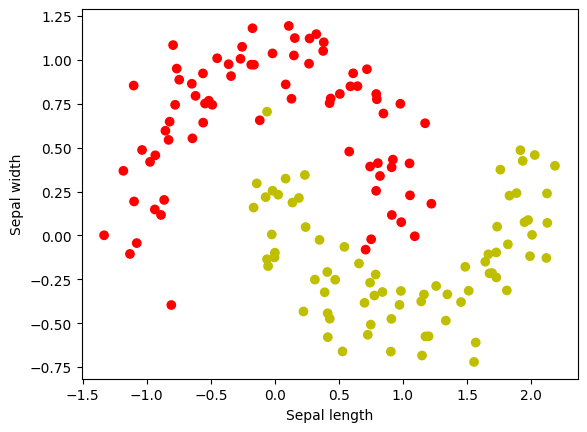

In [15]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option is 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option is 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option is 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option is 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

In [16]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 50),  # Aumentado de 35 para 50 neurônios
            nn.ReLU(),
            nn.Linear(50, 45), # Nova camada com 45 neurônios
            nn.ReLU(),
            nn.Linear(45, 40), # Nova camada com 40 neurônios
            nn.ReLU(),
            nn.Linear(40, 35), # Diminuido da antiga segunda camada para 35 neurônios
            nn.ReLU(),
            nn.Linear(35, 3),  # Camda de saída se mantém a mesma
        )
    
    def forward(self, x):
        x = self.dense(x)
        return x
    
model = Modelo()
print(model)

# A rede agora possui quatro camadas ocultas em vez de duas, 
# e o número de neurônios nessas camadas foi ajustado. 
# As camadas de entrada e saída permanecem inalteradas.


Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=45, bias=True)
    (3): ReLU()
    (4): Linear(in_features=45, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=35, bias=True)
    (7): ReLU()
    (8): Linear(in_features=35, out_features=3, bias=True)
  )
)


In [17]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)
                
                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)
                
                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(self.fig)
                display.clear_output(wait=True)

lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

Final loss: tensor(0.0005)


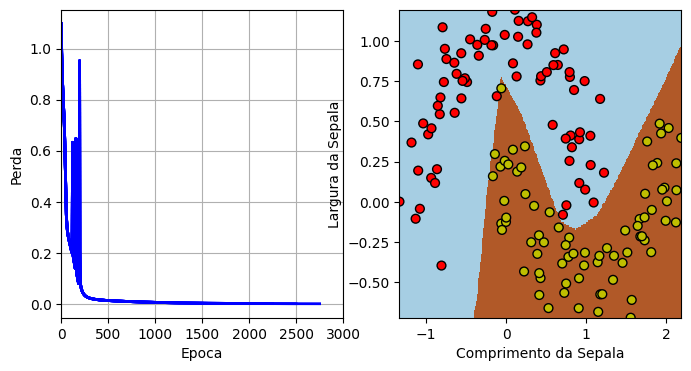

In [18]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})
    
print('Final loss:', loss.data)

In [19]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print() 
print('Training Accuracy: ', accuracy)

import pandas as pd
pd.crosstab(Y_hat, Y)

dense.0.weight  torch.Size([50, 2])
tensor([[ 0.9052,  0.5750],
        [-0.5712, -0.5381],
        [ 0.4934, -0.6172],
        [-0.2796,  0.6143],
        [-0.6149,  0.2038],
        [ 0.5942, -0.5523],
        [ 0.7747,  0.4307],
        [ 0.7698, -0.2951],
        [ 0.0085,  0.1009],
        [ 0.3415,  0.1535],
        [ 0.5598, -0.2828],
        [-0.3154,  0.1328],
        [ 0.6205, -0.7205],
        [ 0.0663, -0.1835],
        [-0.4397,  0.1385],
        [-1.2012, -0.4715],
        [ 0.0894, -0.6356],
        [ 0.7347, -0.3343],
        [ 0.0130, -0.0097],
        [-0.0219, -0.4219],
        [ 0.1583, -0.3106],
        [ 0.7447, -0.4744],
        [ 0.2611, -0.7970],
        [ 0.0398,  0.1119],
        [ 0.0721,  0.3050],
        [-0.7140, -0.2250],
        [-0.5738,  0.5764],
        [ 0.6739, -0.3614],
        [-0.3877, -0.2121],
        [-0.2371, -0.2133],
        [ 0.0085, -0.0197],
        [-0.3751, -0.3315],
        [-0.1961, -0.2875],
        [-0.2200,  0.2429],
        [-0.

col_0,0,1
row_0,,
0,75,0
1,0,75


2.

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if option is 'iris':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'moon':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'circles':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\293536247

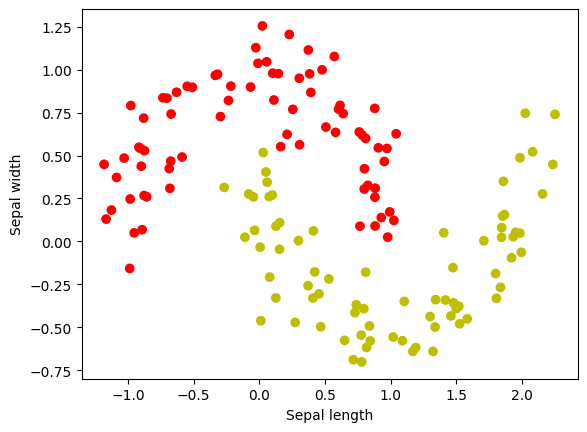

In [22]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option is 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option is 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option is 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option is 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

In [23]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 35),
            nn.Sigmoid(),  # Trocado ReLU por Sigmoid
            nn.Linear(35, 35),
            nn.Sigmoid(),  # Trocado ReLU por Sigmoid
            nn.Linear(35, 3),
        )
    
    def forward(self, x):
        x = self.dense(x)
        return x
    
model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=35, out_features=35, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=35, out_features=3, bias=True)
  )
)


In [24]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)
                
                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)
                
                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(self.fig)
                display.clear_output(wait=True)

lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

Final loss: tensor(0.2422)


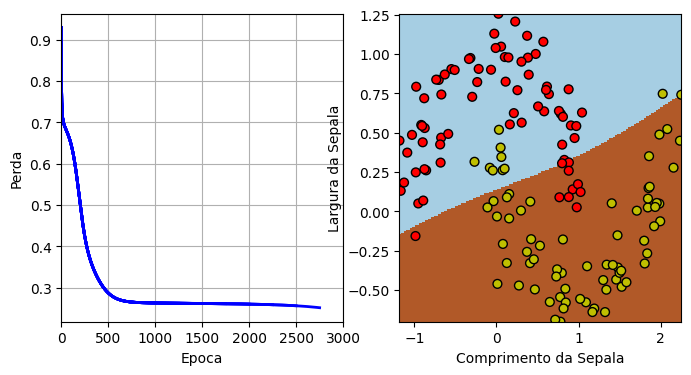

In [25]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})
    
print('Final loss:', loss.data)

In [21]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print() 
print('Training Accuracy: ', accuracy)

import pandas as pd
pd.crosstab(Y_hat, Y)

dense.0.weight  torch.Size([50, 2])
tensor([[ 0.9052,  0.5750],
        [-0.5712, -0.5381],
        [ 0.4934, -0.6172],
        [-0.2796,  0.6143],
        [-0.6149,  0.2038],
        [ 0.5942, -0.5523],
        [ 0.7747,  0.4307],
        [ 0.7698, -0.2951],
        [ 0.0085,  0.1009],
        [ 0.3415,  0.1535],
        [ 0.5598, -0.2828],
        [-0.3154,  0.1328],
        [ 0.6205, -0.7205],
        [ 0.0663, -0.1835],
        [-0.4397,  0.1385],
        [-1.2012, -0.4715],
        [ 0.0894, -0.6356],
        [ 0.7347, -0.3343],
        [ 0.0130, -0.0097],
        [-0.0219, -0.4219],
        [ 0.1583, -0.3106],
        [ 0.7447, -0.4744],
        [ 0.2611, -0.7970],
        [ 0.0398,  0.1119],
        [ 0.0721,  0.3050],
        [-0.7140, -0.2250],
        [-0.5738,  0.5764],
        [ 0.6739, -0.3614],
        [-0.3877, -0.2121],
        [-0.2371, -0.2133],
        [ 0.0085, -0.0197],
        [-0.3751, -0.3315],
        [-0.1961, -0.2875],
        [-0.2200,  0.2429],
        [-0.

col_0,0,1
row_0,,
0,75,2
1,0,73


3.

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if option is 'iris':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'moon':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\2935362474.py:23: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif option is 'circles':
C:\Users\anisi\AppData\Local\Temp\ipykernel_16852\293536247

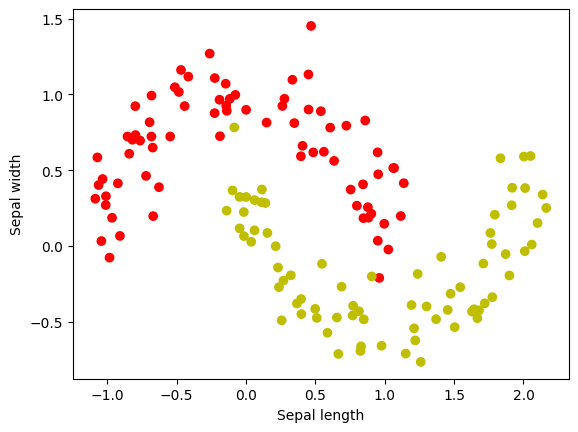

In [31]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option is 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option is 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option is 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option is 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

In [32]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 15),
            nn.Linear(15, 15),
            nn.Linear(15, 5),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


In [33]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data.numpy()

class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            
            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)
                
                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)
                
                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(self.fig)
                display.clear_output(wait=True)

lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

Final loss: tensor(0.2981)


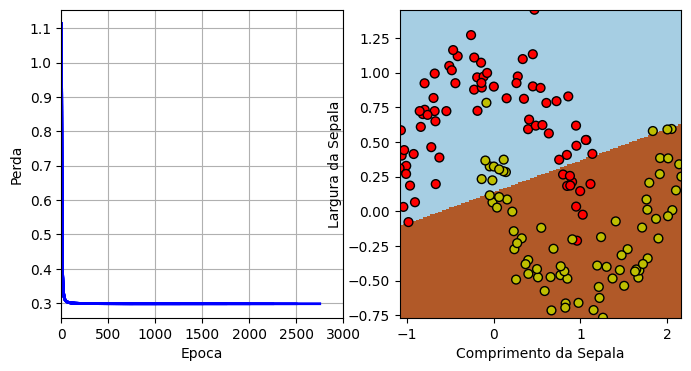

In [34]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})
    
print('Final loss:', loss.data)

In [35]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print() 
print('Training Accuracy: ', accuracy)

import pandas as pd
pd.crosstab(Y_hat, Y)

dense.0.weight  torch.Size([5, 2])
tensor([[ 0.2306, -0.7723],
        [-0.3787,  0.4368],
        [ 0.4175,  0.7810],
        [ 0.2671,  0.1082],
        [-0.3196,  0.7955]])
dense.0.bias    torch.Size([5])
tensor([-0.0426, -0.4117, -0.2223, -0.8611, -0.4630])
dense.1.weight  torch.Size([15, 5])
tensor([[-0.4343,  0.1031,  0.3622, -0.2003,  0.3158],
        [ 0.2754, -0.3817,  0.2534, -0.2215, -0.4300],
        [-0.0779, -0.2604,  0.0966, -0.1705, -0.3648],
        [-0.0404,  0.0355, -0.0642, -0.1022, -0.2852],
        [ 0.4226, -0.4747, -0.4396, -0.3599, -0.4525],
        [ 0.3367, -0.3998, -0.3973,  0.3093,  0.3891],
        [ 0.4784, -0.1581, -0.3392,  0.2787, -0.2669],
        [ 0.3821, -0.3364, -0.3738, -0.1359, -0.0325],
        [-0.1485, -0.3245, -0.4432, -0.0305, -0.1774],
        [-0.4789, -0.2176, -0.0759, -0.3835, -0.0541],
        [-0.3859,  0.1956, -0.1607, -0.3451,  0.3761],
        [ 0.0646, -0.3818,  0.3001,  0.2498, -0.1433],
        [ 0.2720, -0.0439,  0.0549, -0.238

col_0,0,1
row_0,,
0,65,11
1,10,64


## Principais aprendizados

1. Ao ajustar as camadas para uma rede com quatro camadas ocultas em vez de duas, e ajustar o número de neurônios nessas camadas, mantendo as entradas e saídas intalteradas, percebemos que o modelo tende a ter um resultado exemplar ao final do treinamento, mantendo 100% de acurácia.
2. Quando voltamos a rede para a original e alteramos as funções ReLU para Sigmoid percebemos que o modelo não consegue mais separar tão bem as classes.
3. Quando alteramos a rede para termos apenas funções lineares, isto é, quando não se utiliza uma função de ativação não linear entre as camadas de um modelo de rede neural, como o Sigmoid ou ReLU, as camadas subsequentes do modelo acabam realizando apenas transformações lineares dos dados de entrada. Isso significa que, não importa quantas camadas lineares empilhe-mos, a rede ainda será capaz de realizar apenas transformações lineares dos dados de entrada para a saída.